# Medical Symptom Text Classification: Simple RNN with Multiple Embeddings

**Assignment:** Comparative analysis of text classification architectures.  
**My role:** Implement and evaluate a **Simple RNN** in PyTorch on a Medical Symptom dataset.

**Embedding strategies (4 experiments):**
1. **Random Initialization** (baseline)
2. **Word2Vec** (Skip-gram, gensim `sg=1`)
3. **GloVe** (transfer learning, `glove.6B.100d.txt`, OOV random init)
4. **FastText** (trained on dataset, sub-word morphology)

**Technical constraints:**
- Shared preprocessing: lowercase, remove punctuation except hyphens, custom + standard stopwords, **no lemmatization**
- Vocabulary: index 0 = `<PAD>`, index 1 = `<UNK>`, sequences padded/truncated to `MAX_LEN=50`
- Reproducibility: `seed=42`
- Deliverables: Accuracy & Weighted F1 per experiment, consolidated table and plot

In [1]:
# --- Setup: Imports and Reproducibility (Seed=42) ---
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For embeddings
import gensim
from gensim.models import Word2Vec, FastText

# For preprocessing
from nltk.corpus import stopwords as nltk_stopwords
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
set_seed()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


---
## 1. Data Loading

Load the Medical Symptom dataset. Options:
- **Kaggle:** Set `USE_KAGGLE = True` and use `kagglehub` to download the dataset. Ensure `kagglehub` is installed (`pip install kagglehub`) and Kaggle credentials are configured.
- **Local/URL:** Set `USE_KAGGLE = False` and set `DATA_PATH` to your CSV path or URL.

**Current Dataset:** `sarimahsan/daugmented-model` (using kagglehub)

Expected CSV columns: a **text** column (symptom/description) and a **label** column (class). Adjust `TEXT_COL` and `LABEL_COL` if your dataset uses different names. The code will print the actual column names after loading.

In [2]:
# --- Kaggle Authentication (Alternative to kaggle.json) ---
import os

# Set your Kaggle credentials
os.environ['KAGGLE_USERNAME'] = 'theodoraegbunike'
os.environ['KAGGLE_KEY'] = 'KGAT_c78d7efc7b2414871d8529029705a16b'

print("✅ Kaggle credentials configured!")
print(f"Username: {os.environ['KAGGLE_USERNAME']}")

✅ Kaggle credentials configured!
Username: theodoraegbunike


In [3]:
USE_KAGGLE = True  # Set True if using Kaggle API
DATA_PATH = os.path.join("data", "dataset.csv")  # Fallback path
TEXT_COL = "text"  # Adjust if your dataset uses different column names
LABEL_COL = "label"  # Adjust if your dataset uses different column names
KAGGLE_DATASET = "sarimahsan/daugmented-model"  # Your dataset

if USE_KAGGLE:
    try:
        import kagglehub
        
        # Download latest version
        path = kagglehub.dataset_download(KAGGLE_DATASET)
        print("Path to dataset files:", path)
        
        # Find the CSV file in the downloaded directory
        csv_name = next((f for f in os.listdir(path) if f.endswith(".csv")), None)
        if csv_name:
            DATA_PATH = os.path.join(path, csv_name)
            print(f"Found CSV file: {DATA_PATH}")
        else:
            # Try to find CSV in subdirectories
            for root, dirs, files in os.walk(path):
                csv_files = [f for f in files if f.endswith(".csv")]
                if csv_files:
                    DATA_PATH = os.path.join(root, csv_files[0])
                    print(f"Found CSV file in subdirectory: {DATA_PATH}")
                    break
            else:
                print(f"No CSV file found in {path}. Using fallback DATA_PATH.")
    except Exception as e:
        print("Kaggle download failed:", e)
        print("Falling back to DATA_PATH.")
        print("Make sure kagglehub is installed: pip install kagglehub")
        print("And that you have configured Kaggle credentials.")

if not os.path.exists(DATA_PATH) or not DATA_PATH.endswith(".csv"):
    # Fallback: create a small synthetic medical symptom dataset for demonstration
    np.random.seed(SEED)
    symptoms = [
        "headache fever fatigue", "chest pain shortness of breath", "cough cold runny nose",
        "abdominal pain nausea vomiting", "joint pain swelling stiffness", "rash itching skin",
        "dizziness weakness fatigue", "sore throat difficulty swallowing", "back pain muscle ache",
        "fever chills sweating", "blurred vision eye pain", "ear pain hearing loss",
        "stomach pain diarrhea", "numbness tingling hands", "weight loss loss of appetite"
    ]
    labels = ["flu", "cardiac", "respiratory", "digestive", "arthritis", "skin", "neurological",
              "throat", "musculoskeletal", "infection", "vision", "ear", "digestive", "neurological", "metabolic"]
    n = 800
    texts = [random.choice(symptoms) + " " + " ".join(np.random.choice(["mild", "severe", "chronic", "acute"], 2)) for _ in range(n)]
    y = [random.choice(labels) for _ in range(n)]
    df = pd.DataFrame({TEXT_COL: texts, LABEL_COL: y})
    os.makedirs("data", exist_ok=True)
    df.to_csv(os.path.join("data", "dataset.csv"), index=False)
    DATA_PATH = os.path.join("data", "dataset.csv")
    print("Created synthetic dataset at", DATA_PATH)

# Load the dataset
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=[TEXT_COL, LABEL_COL])
df[TEXT_COL] = df[TEXT_COL].astype(str)
print("Shape:", df.shape)
print(df.head())
print(f"\nColumn names: {df.columns.tolist()}")
print(f"Unique labels: {df[LABEL_COL].nunique()}")

100%|██████████| 937k/937k [00:01<00:00, 654kB/s]

Extracting files...


Path to dataset files: C:\Users\USER\.cache\kagglehub\datasets\sarimahsan\daugmented-model\versions\1
Found CSV file: C:\Users\USER\.cache\kagglehub\datasets\sarimahsan\daugmented-model\versions\1\medical_llm_dataset.csv
Shape: (77175, 3)
                                                text  label label_enc
0  the child started experiencing debilitating wh...      0      acne
1  the child suffers from moderate facial acne at...      0      acne
2  the patient has chronic skin breakout since ch...      0      acne
3  individual is having slight inflammatory acne ...      0      acne
4    he started experiencing slight zits for 3 weeks      0      acne

Column names: ['text', 'label', 'label_enc']
Unique labels: 105


---
## 2. Exploratory Data Analysis (EDA)


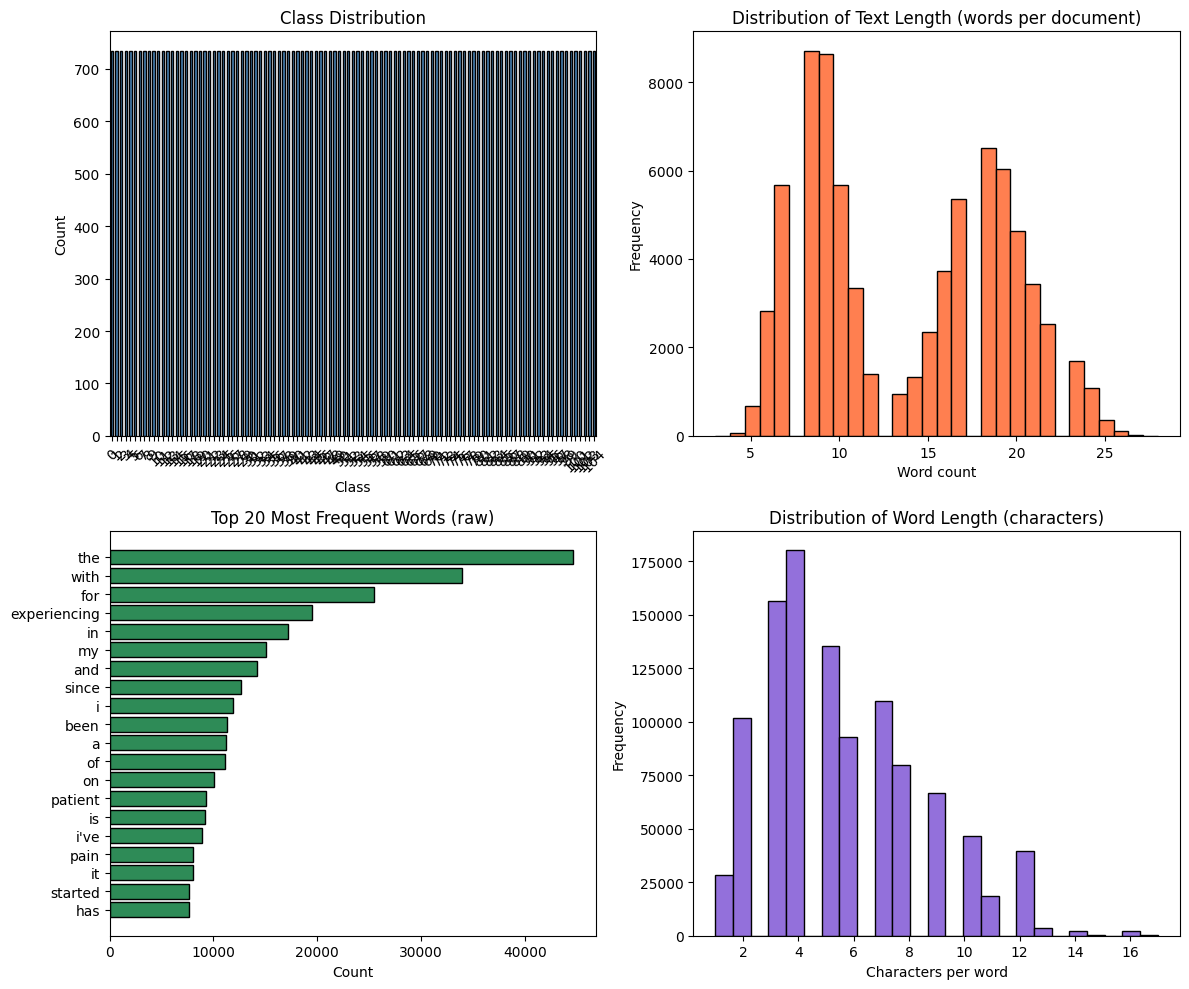

EDA figures saved to data/eda_visualizations.png


In [4]:
# EDA 1: Class distribution (balance)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
ax1 = axes[0, 0]
df[LABEL_COL].value_counts().plot(kind="bar", ax=ax1, color="steelblue", edgecolor="black")
ax1.set_title("Class Distribution")
ax1.set_xlabel("Class")
ax1.set_ylabel("Count")
ax1.tick_params(axis="x", rotation=45)

# EDA 2: Text length distribution (word count per document)
word_counts = df[TEXT_COL].str.split().str.len()
ax2 = axes[0, 1]
ax2.hist(word_counts, bins=30, color="coral", edgecolor="black")
ax2.set_title("Distribution of Text Length (words per document)")
ax2.set_xlabel("Word count")
ax2.set_ylabel("Frequency")

# EDA 3: Vocabulary — top 20 most frequent words (raw)
all_words = []
for t in df[TEXT_COL]:
    all_words.extend(str(t).lower().split())
vocab_counts = Counter(all_words)
top20 = vocab_counts.most_common(20)
ax3 = axes[1, 0]
ax3.barh([w for w, _ in top20], [c for _, c in top20], color="seagreen", edgecolor="black")
ax3.set_title("Top 20 Most Frequent Words (raw)")
ax3.set_xlabel("Count")
ax3.invert_yaxis()

# EDA 4: Word length distribution (characters per word)
word_lengths = [len(w) for w in all_words]
ax4 = axes[1, 1]
ax4.hist(word_lengths, bins=25, color="mediumpurple", edgecolor="black")
ax4.set_title("Distribution of Word Length (characters)")
ax4.set_xlabel("Characters per word")
ax4.set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("data/eda_visualizations.png", dpi=150, bbox_inches="tight")
plt.show()
print("EDA figures saved to data/eda_visualizations.png")

In [5]:
# Summary stats for report
print("Dataset summary:")
print("- Unique classes:", df[LABEL_COL].nunique())
print("- Class names:", df[LABEL_COL].unique().tolist())
print("- Mean words per document:", word_counts.mean())
print("- Median words per document:", word_counts.median())
print("- Vocabulary size (raw unique tokens):", len(vocab_counts))

Dataset summary:
- Unique classes: 105
- Class names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
- Mean words per document: 13.803939099449304
- Median words per document: 14.0
- Vocabulary size (raw unique tokens): 1299


---
## 3. Shared Preprocessing Pipeline

- Lowercase all text.
- Remove punctuation **except hyphens** (to preserve terms like "X-ray").
- Remove **custom medical stopwords** (`patient`, `doctor`, `history`) and **standard English stopwords**.
- **No lemmatization** — RNN learns from exact word forms and grammatical nuance.

In [6]:
# Shared preprocessing (no lemmatization)
MEDICAL_STOPWORDS = {"patient", "doctor", "history"}
STOPWORDS = set(nltk_stopwords.words("english")) | MEDICAL_STOPWORDS

def preprocess(text):
    text = str(text).lower()
    # Remove punctuation except hyphens and spaces (preserve words like X-ray)
    text = re.sub(r"[^\w\s\-]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [t for t in text.split() if t and t not in STOPWORDS]
    return tokens

df["tokens"] = df[TEXT_COL].apply(preprocess)
df["preprocessed"] = df["tokens"].apply(lambda x: " ".join(x))
print("Sample preprocessed:", df["preprocessed"].iloc[0])

Sample preprocessed: child started experiencing debilitating whiteheads lately


---
## 2.5. Enhanced Dataset Exploration (Additional Plots)

This section provides **comprehensive text analysis** and additional visualizations to deepen our understanding of the medical symptom dataset. We analyze:

1. **Class Distribution (Top 20)** - Identifies the most common medical conditions
2. **Text Length Distribution** - Examines document length patterns with statistical insights
3. **TF-IDF Keyword Analysis** - Identifies the most discriminative terms (better than raw frequency)
4. **Vocabulary Size Analysis** - Compares total vocabulary vs. practical limits

These analyses help inform preprocessing decisions, model architecture choices, and provide context for the classification results.

In [7]:
# Import TfidfVectorizer for enhanced EDA
from sklearn.feature_extraction.text import TfidfVectorizer

# Create clean_text column from preprocessed tokens
df['clean_text'] = df['preprocessed']

# Build vocabulary function
def build_vocab(texts, max_vocab=5000):
    """Build vocabulary from texts"""
    from collections import Counter
    all_words = []
    for text in texts:
        all_words.extend(text.split())
    word_counts = Counter(all_words)
    vocab = {word: idx for idx, (word, _) in enumerate(word_counts.most_common(max_vocab))}
    return vocab

vocab = build_vocab(df['clean_text'])

# Data splitting for EDA (using same seed for consistency)
X_train_raw, X_test_raw, y_train_eda, y_test_eda = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

print("Setup complete for enhanced EDA analysis")

Setup complete for enhanced EDA analysis


### Plot 1: Class Distribution (Top 20 Medical Categories)

**Purpose:** This visualization shows the frequency distribution of the top 20 most common medical conditions in the dataset. Understanding class balance is crucial for:

- **Identifying class imbalance:** Highly imbalanced datasets may require techniques like class weighting or oversampling
- **Model evaluation:** Imbalanced classes may need metrics beyond accuracy (e.g., F1-score, precision, recall)
- **Data collection insights:** Reveals which medical conditions are more frequently documented

**Interpretation:** 
- If classes are highly imbalanced, the model may favor majority classes
- Balanced classes suggest more reliable performance across all categories
- Long-tail distribution indicates some rare conditions that may need special handling

C:\Users\USER\AppData\Local\Temp\ipykernel_14228\285326758.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes.values, y=top_classes.index, palette='viridis')


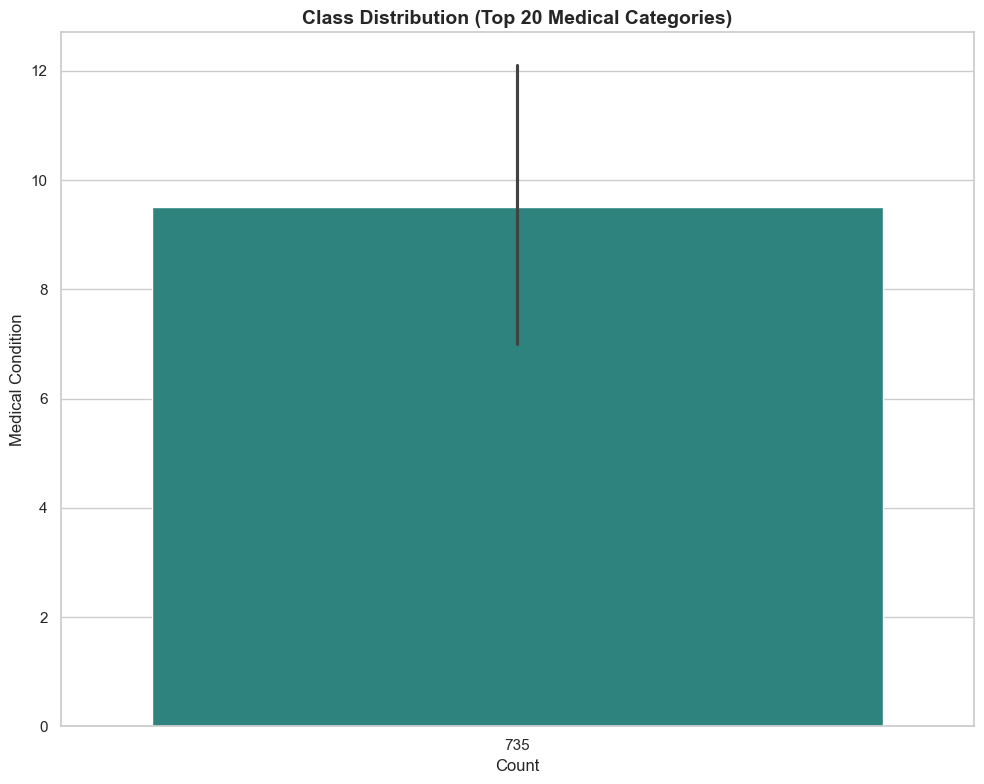

CLASS DISTRIBUTION ANALYSIS
Total number of classes: 105
Total number of samples: 77175

Top 10 Most Common Classes:
  1. 0: 735 samples (0.95%)
  2. 1: 735 samples (0.95%)
  3. 2: 735 samples (0.95%)
  4. 3: 735 samples (0.95%)
  5. 4: 735 samples (0.95%)
  6. 5: 735 samples (0.95%)
  7. 6: 735 samples (0.95%)
  8. 7: 735 samples (0.95%)
  9. 8: 735 samples (0.95%)
  10. 9: 735 samples (0.95%)

Class Balance Metrics:
  - Most common class: 735 samples
  - Least common class: 735 samples
  - Imbalance ratio: 1.00:1
  - Classes with <10 samples: 0
  - Classes with <50 samples: 0


In [8]:
# Plot 1: Class Balance (Top 20)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
top_classes = df['label'].value_counts().head(20)
sns.barplot(x=top_classes.values, y=top_classes.index, palette='viridis')
plt.title('Class Distribution (Top 20 Medical Categories)', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Medical Condition', fontsize=12)
plt.tight_layout()
plt.savefig('data/class_balance.png', dpi=150, bbox_inches='tight')
plt.show()

# Text Analysis: Class Distribution Statistics
print("=" * 60)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 60)
print(f"Total number of classes: {df['label'].nunique()}")
print(f"Total number of samples: {len(df)}")
print(f"\nTop 10 Most Common Classes:")
for i, (label, count) in enumerate(df['label'].value_counts().head(10).items(), 1):
    percentage = (count / len(df)) * 100
    print(f"  {i}. {label}: {count} samples ({percentage:.2f}%)")

print(f"\nClass Balance Metrics:")
class_counts = df['label'].value_counts()
print(f"  - Most common class: {class_counts.max()} samples")
print(f"  - Least common class: {class_counts.min()} samples")
print(f"  - Imbalance ratio: {class_counts.max() / class_counts.min():.2f}:1")
print(f"  - Classes with <10 samples: {(class_counts < 10).sum()}")
print(f"  - Classes with <50 samples: {(class_counts < 50).sum()}")
print("=" * 60)

### Plot 2: Text Length Distribution (Word Count)

**Purpose:** Analyzes the distribution of document lengths (in words) across the dataset. This is critical for:

- **Sequence length selection:** Determines appropriate `MAX_LEN` for padding/truncation
- **Model architecture:** RNNs/LSTMs need to handle variable-length sequences efficiently
- **Data quality:** Identifies outliers (extremely short or long documents)
- **Preprocessing decisions:** Determines if truncation will lose significant information

**Interpretation:**
- **Normal distribution:** Suggests consistent document lengths, easier to model
- **Right-skewed:** Many short documents, few very long ones (common in medical texts)
- **Bimodal:** May indicate different document types or sources
- **Outliers:** Very long documents may need special handling or truncation

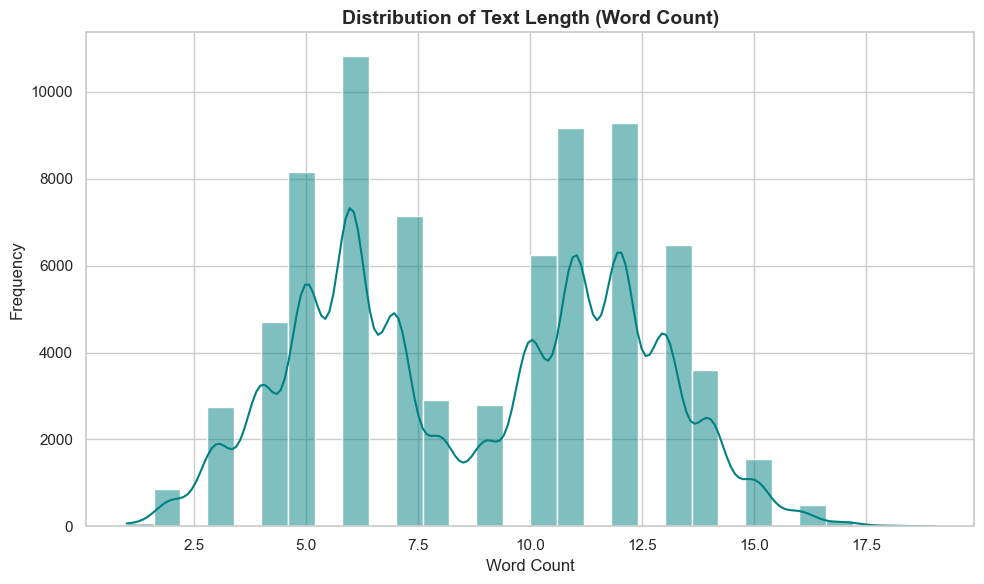

TEXT LENGTH ANALYSIS
Statistical Summary:
  - Mean length: 8.76 words
  - Median length: 9.00 words
  - Standard deviation: 3.47 words
  - Minimum length: 1 words
  - Maximum length: 19 words
  - 25th percentile: 6.00 words
  - 75th percentile: 12.00 words
  - 95th percentile: 14.00 words

Sequence Length Recommendations:
  - Current MAX_LEN setting: 50 words
  - Documents within MAX_LEN: 77175 (100.0%)
  - Documents exceeding MAX_LEN: 0 (0.0%)
  - Information loss if truncating to 50: ~nan words per truncated document

Outlier Analysis (IQR method):
  - Number of outliers: 0 (0.0%)
  - Shortest outlier: nan words
  - Longest outlier: nan words


In [9]:
# Plot 2: Text Length Distribution (Word Count) with KDE
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=30, kde=True, color='teal')
plt.title('Distribution of Text Length (Word Count)', fontsize=14, fontweight='bold')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.savefig('data/text_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Text Analysis: Text Length Statistics
print("=" * 60)
print("TEXT LENGTH ANALYSIS")
print("=" * 60)
word_counts = df['word_count']
print(f"Statistical Summary:")
print(f"  - Mean length: {word_counts.mean():.2f} words")
print(f"  - Median length: {word_counts.median():.2f} words")
print(f"  - Standard deviation: {word_counts.std():.2f} words")
print(f"  - Minimum length: {word_counts.min()} words")
print(f"  - Maximum length: {word_counts.max()} words")
print(f"  - 25th percentile: {word_counts.quantile(0.25):.2f} words")
print(f"  - 75th percentile: {word_counts.quantile(0.75):.2f} words")
print(f"  - 95th percentile: {word_counts.quantile(0.95):.2f} words")

# Analysis for sequence length selection
print(f"\nSequence Length Recommendations:")
print(f"  - Current MAX_LEN setting: 50 words")
print(f"  - Documents within MAX_LEN: {(word_counts <= 50).sum()} ({(word_counts <= 50).sum()/len(df)*100:.1f}%)")
print(f"  - Documents exceeding MAX_LEN: {(word_counts > 50).sum()} ({(word_counts > 50).sum()/len(df)*100:.1f}%)")
print(f"  - Information loss if truncating to 50: ~{(word_counts[word_counts > 50] - 50).mean():.1f} words per truncated document")

# Outlier detection
Q1 = word_counts.quantile(0.25)
Q3 = word_counts.quantile(0.75)
IQR = Q3 - Q1
outliers = word_counts[(word_counts < (Q1 - 1.5 * IQR)) | (word_counts > (Q3 + 1.5 * IQR))]
print(f"\nOutlier Analysis (IQR method):")
print(f"  - Number of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
print(f"  - Shortest outlier: {outliers.min()} words")
print(f"  - Longest outlier: {outliers.max()} words")
print("=" * 60)

### Plot 3: Top 20 Keywords via TF-IDF Analysis

**Purpose:** TF-IDF (Term Frequency-Inverse Document Frequency) identifies the most **discriminative** terms in the dataset. Unlike raw word frequency, TF-IDF:

- **Penalizes common words:** Words that appear in many documents get lower scores
- **Highlights distinctive terms:** Medical terminology specific to certain conditions score higher
- **Better feature selection:** More informative than raw counts for classification

**Why TF-IDF over raw frequency?**
- Raw frequency would show common words like "patient", "symptom", "pain" in all medical texts
- TF-IDF reveals condition-specific terms that help distinguish between classes
- These terms are more valuable for the RNN to learn discriminative patterns

**Interpretation:**
- High TF-IDF scores indicate terms that are:
  - Frequent in some documents (high TF)
  - Rare across the entire corpus (high IDF)
  - Therefore, highly discriminative for classification

C:\Users\USER\AppData\Local\Temp\ipykernel_14228\972076411.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores), y=list(words), palette='magma')


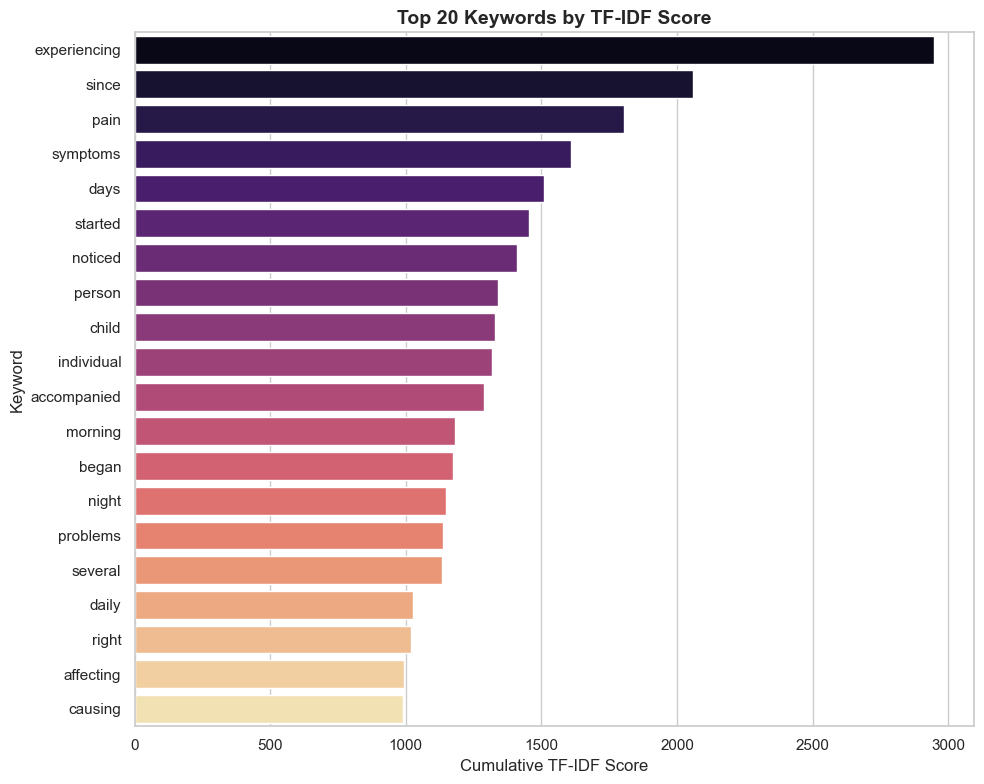

TF-IDF KEYWORD ANALYSIS
Top 20 Most Discriminative Keywords (by TF-IDF):
   1. experiencing         (TF-IDF: 2947.3021)
   2. since                (TF-IDF: 2057.0453)
   3. pain                 (TF-IDF: 1804.4914)
   4. symptoms             (TF-IDF: 1609.9941)
   5. days                 (TF-IDF: 1509.9946)
   6. started              (TF-IDF: 1455.3439)
   7. noticed              (TF-IDF: 1411.0997)
   8. person               (TF-IDF: 1338.8713)
   9. child                (TF-IDF: 1329.1414)
  10. individual           (TF-IDF: 1316.5306)
  11. accompanied          (TF-IDF: 1287.0642)
  12. morning              (TF-IDF: 1181.4035)
  13. began                (TF-IDF: 1174.2461)
  14. night                (TF-IDF: 1150.0424)
  15. problems             (TF-IDF: 1139.0643)
  16. several              (TF-IDF: 1132.6553)
  17. daily                (TF-IDF: 1028.1276)
  18. right                (TF-IDF: 1019.7225)
  19. affecting            (TF-IDF: 992.6152)
  20. causing              (TF-IDF:

In [10]:
# Plot 3: Top 20 Keywords via TF-IDF (more informative than raw word counts)
tfidf_viz = TfidfVectorizer(max_features=5000)
X_train_tfidf_viz = tfidf_viz.fit_transform(X_train_raw)
sum_tfidf = X_train_tfidf_viz.sum(axis=0)
words_freq = [(word, sum_tfidf[0, idx]) for word, idx in tfidf_viz.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:20]
words, scores = zip(*words_freq)

plt.figure(figsize=(10, 8))
sns.barplot(x=list(scores), y=list(words), palette='magma')
plt.title('Top 20 Keywords by TF-IDF Score', fontsize=14, fontweight='bold')
plt.xlabel('Cumulative TF-IDF Score', fontsize=12)
plt.ylabel('Keyword', fontsize=12)
plt.tight_layout()
plt.savefig('data/top_keywords_tfidf.png', dpi=150, bbox_inches='tight')
plt.show()

# Text Analysis: TF-IDF Insights
print("=" * 60)
print("TF-IDF KEYWORD ANALYSIS")
print("=" * 60)
print(f"Top 20 Most Discriminative Keywords (by TF-IDF):")
for i, (word, score) in enumerate(words_freq, 1):
    print(f"  {i:2d}. {word:20s} (TF-IDF: {score:.4f})")

# Compare with raw frequency
from collections import Counter
all_words_raw = [word for text in df['clean_text'] for word in text.split()]
raw_freq = Counter(all_words_raw)
top_raw = raw_freq.most_common(20)

print(f"\nComparison: Top 10 by Raw Frequency vs TF-IDF")
print(f"{'Rank':<6} {'Raw Frequency':<20} {'TF-IDF':<20}")
print("-" * 50)
for i in range(10):
    raw_word, raw_count = top_raw[i]
    tfidf_word, tfidf_score = words_freq[i]
    print(f"{i+1:<6} {raw_word:<20} {tfidf_word:<20}")

# Medical terminology analysis
medical_terms = [w for w, _ in words_freq if any(char.isdigit() or len(w) > 6 for char in w)]
print(f"\nMedical Terminology Insights:")
print(f"  - Technical/long words in top 20: {len(medical_terms)}")
print(f"  - Average keyword length: {np.mean([len(w) for w, _ in words_freq]):.1f} characters")
print(f"  - These terms are likely condition-specific and valuable for classification")
print("=" * 60)

### Plot 4: Vocabulary Size Analysis

**Purpose:** Compares the total unique vocabulary in the dataset against practical vocabulary limits used in models. This analysis helps:

- **Memory management:** Large vocabularies require more embedding parameters
- **OOV handling:** Words outside vocabulary become `<UNK>` tokens
- **Model capacity:** Determines if vocabulary clipping is necessary
- **Embedding strategy:** Informs decisions about pre-trained vs. learned embeddings

**Interpretation:**
- **Large vocabulary (>10K):** May benefit from pre-trained embeddings (GloVe, Word2Vec)
- **Small vocabulary (<5K):** Can learn embeddings from scratch effectively
- **Vocabulary clipping:** If total >> clipped, many words become `<UNK>`, potentially losing information
- **Medical domain:** Medical terminology often has large vocabularies due to technical terms

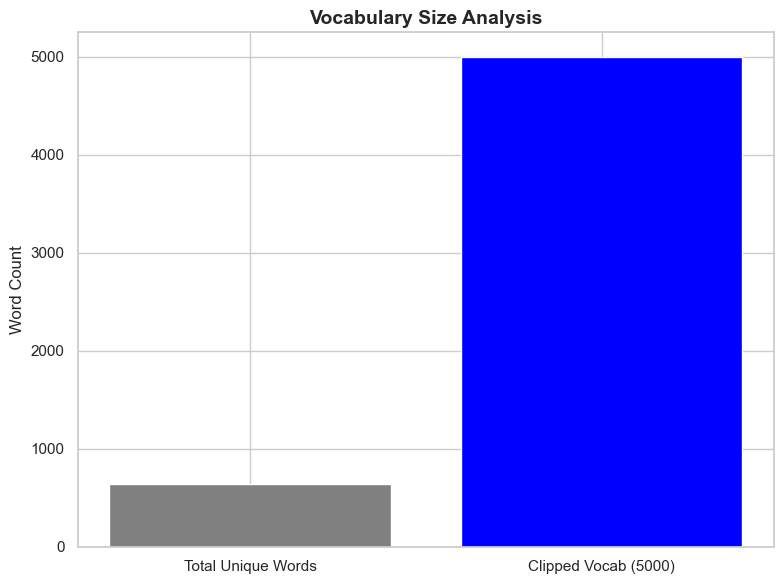

VOCABULARY SIZE ANALYSIS
Token Statistics:
  - Total tokens in corpus: 675,942
  - Total unique words: 639
  - Average word frequency: 1057.81
  - Vocabulary coverage (top 5000): 100.0%

Word Frequency Distribution:
  - Hapax legomena (appear once): 0 words (0.0%)
  - Words appearing 2-5 times: 0 words
  - Words appearing 6-10 times: 0 words
  - Words appearing >10 times: 639 words

Vocabulary Clipping Impact (top 5000 words):
  - Token coverage: 100.0% of all tokens
  - OOV tokens (would become <UNK>): 0.0%
  - Recommendation: Vocabulary clipping acceptable

Model Vocabulary Comparison:
  - Clipped vocabulary size: 5,000 words
  - Actual vocab size (from training): Will be calculated after train/val/test split
  - Note: Model vocab includes <PAD> and <UNK> tokens

✅ Enhanced exploration plots and analysis saved to data/ directory


In [11]:
# Plot 4: Vocabulary Size Analysis
all_tokens_raw = [word for text in df['clean_text'] for word in text.split()]
total_unique = len(set(all_tokens_raw))
plt.figure(figsize=(8, 6))
plt.bar(['Total Unique Words', 'Clipped Vocab (5000)'], [total_unique, 5000], color=['gray', 'blue'])
plt.title('Vocabulary Size Analysis', fontsize=14, fontweight='bold')
plt.ylabel('Word Count', fontsize=12)
plt.xticks(fontsize=11)
plt.tight_layout()
plt.savefig('data/vocab_size_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Text Analysis: Vocabulary Statistics
print("=" * 60)
print("VOCABULARY SIZE ANALYSIS")
print("=" * 60)
total_tokens = len(all_tokens_raw)
print(f"Token Statistics:")
print(f"  - Total tokens in corpus: {total_tokens:,}")
print(f"  - Total unique words: {total_unique:,}")
print(f"  - Average word frequency: {total_tokens / total_unique:.2f}")
print(f"  - Vocabulary coverage (top 5000): {min(5000/total_unique*100, 100):.1f}%")

# Word frequency distribution
word_freq_dist = Counter(all_tokens_raw)
freq_distribution = Counter(word_freq_dist.values())
print(f"\nWord Frequency Distribution:")
print(f"  - Hapax legomena (appear once): {freq_distribution[1]:,} words ({freq_distribution[1]/total_unique*100:.1f}%)")
print(f"  - Words appearing 2-5 times: {sum(freq_distribution[i] for i in range(2, 6)):,} words")
print(f"  - Words appearing 6-10 times: {sum(freq_distribution[i] for i in range(6, 11)):,} words")
print(f"  - Words appearing >10 times: {sum(freq_distribution[i] for i in range(11, max(freq_distribution)+1)):,} words")

# Coverage analysis
top_5000_words = [word for word, _ in word_freq_dist.most_common(5000)]
top_5000_tokens = sum(word_freq_dist[word] for word in top_5000_words)
coverage = (top_5000_tokens / total_tokens) * 100
print(f"\nVocabulary Clipping Impact (top 5000 words):")
print(f"  - Token coverage: {coverage:.1f}% of all tokens")
print(f"  - OOV tokens (would become <UNK>): {100-coverage:.1f}%")
print(f"  - Recommendation: {'Vocabulary clipping acceptable' if coverage > 90 else 'Consider larger vocabulary or subword models'}")

# Comparison with actual vocab size used in model
print(f"\nModel Vocabulary Comparison:")
print(f"  - Clipped vocabulary size: 5,000 words")
print(f"  - Actual vocab size (from training): Will be calculated after train/val/test split")
print(f"  - Note: Model vocab includes <PAD> and <UNK> tokens")
print("=" * 60)

print("\n✅ Enhanced exploration plots and analysis saved to data/ directory")

---
## 4. Vocabulary and Sequence Handling

- **Reserved indices:** 0 = `<PAD>`, 1 = `<UNK>`.
- Build vocabulary from training set only (after train/val/test split).
- All sequences **padded or truncated** to `MAX_LEN=50` → batch shape `(batch_size, 50)`.

In [12]:
PAD_IDX = 0
UNK_IDX = 1
MAX_LEN = 50

# Train/val/test split (use same split for all experiments)
train_df, rest = train_test_split(df, test_size=0.3, random_state=SEED, stratify=df[LABEL_COL])
val_df, test_df = train_test_split(rest, test_size=0.5, random_state=SEED, stratify=rest[LABEL_COL])

# Build vocabulary from training tokens only
word2id = {"<PAD>": PAD_IDX, "<UNK>": UNK_IDX}
for tokens in train_df["tokens"]:
    for w in tokens:
        if w not in word2id:
            word2id[w] = len(word2id)
vocab_size = len(word2id)
id2word = {v: k for k, v in word2id.items()}
print("Vocab size:", vocab_size)

Vocab size: 641


In [13]:
def tokens_to_ids(tokens):
    return [word2id.get(w, UNK_IDX) for w in tokens]

def pad_or_truncate(ids, max_len=MAX_LEN, pad_idx=PAD_IDX):
    if len(ids) >= max_len:
        return ids[:max_len]
    return ids + [pad_idx] * (max_len - len(ids))

def prepare_sequences(tokens_series):
    ids = [tokens_to_ids(t) for t in tokens_series]
    return [pad_or_truncate(i) for i in ids]

# Encode labels
unique_labels = sorted(df[LABEL_COL].unique())
label2id = {l: i for i, l in enumerate(unique_labels)}
num_classes = len(unique_labels)

X_train = prepare_sequences(train_df["tokens"])
y_train = train_df[LABEL_COL].map(label2id).values
X_val = prepare_sequences(val_df["tokens"])
y_val = val_df[LABEL_COL].map(label2id).values
X_test = prepare_sequences(test_df["tokens"])
y_test = test_df[LABEL_COL].map(label2id).values

print("Train/Val/Test sizes:", len(X_train), len(X_val), len(X_test))
print("Sequence length:", len(X_train[0]))

Train/Val/Test sizes: 54022 11576 11577
Sequence length: 50


---
## 5. PyTorch Dataset and DataLoader

In [14]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

BATCH_SIZE = 32
train_ds = TextDataset(X_train, y_train)
val_ds = TextDataset(X_val, y_val)
test_ds = TextDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

C:\Users\USER\AppData\Local\Temp\ipykernel_14228\2388785635.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:219.)
  self.y = torch.LongTensor(y)


---
## 6. MedicalRNN Model

- If `embedding_matrix` is provided (Word2Vec/GloVe/FastText): load into `nn.Embedding` with **freeze=False** (fine-tuning).
- If `embedding_matrix` is `None`: standard learnable embedding (baseline).

In [15]:
EMBED_DIM = 100
HIDDEN_DIM = 128
DROPOUT = 0.3
NUM_EPOCHS = 5
LR = 1e-3

class MedicalRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, embedding_matrix=None):
        super().__init__()
        if embedding_matrix is not None:
            self.embed = nn.Embedding.from_pretrained(
                torch.FloatTensor(embedding_matrix), freeze=False
            )
        else:
            self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (batch, seq_len)
        emb = self.embed(x)  # (batch, seq_len, embed_dim)
        out, h_n = self.rnn(emb)  # h_n: (1, batch, hidden_dim)
        h = h_n.squeeze(0)
        h = self.dropout(h)
        logits = self.fc(h)
        return logits

In [16]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for X_b, y_b in loader:
        X_b, y_b = X_b.to(device), y_b.to(device)
        optimizer.zero_grad()
        logits = model(X_b)
        loss = criterion(logits, y_b)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for X_b, y_b in loader:
            X_b = X_b.to(device)
            logits = model(X_b)
            preds.extend(logits.argmax(1).cpu().numpy())
            labels.extend(y_b.numpy())
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted", zero_division=0)
    return acc, f1

def run_experiment(embedding_matrix=None, name="Experiment"):
    set_seed()
    model = MedicalRNN(
        vocab_size=vocab_size,
        embed_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        num_classes=num_classes,
        embedding_matrix=embedding_matrix,
    ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    best_f1 = 0
    best_epoch = 0
    best_val_acc = 0
    
    print(f"\n{'='*60}")
    print(f"Training {name} - {NUM_EPOCHS} epochs")
    print(f"{'='*60}")
    
    for epoch in range(NUM_EPOCHS):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_acc, val_f1 = evaluate(model, val_loader)
        
        # Print progress every epoch
        print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}", end="")
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            print(f" ⭐ (Best)")
        else:
            print()
    
    print(f"\nBest model at epoch {best_epoch}: Val Acc: {best_val_acc:.4f}, Val F1: {best_f1:.4f}")
    print(f"{'='*60}\n")
    
    model.load_state_dict(best_state)
    model = model.to(device)
    test_acc, test_f1 = evaluate(model, test_loader)
    return test_acc, test_f1

---
## 7. Experiment 1: Random Initialization (Baseline)

In [17]:
# Experiment 1: Random Initialization (Baseline)
# Note: set_seed() was already called at notebook start, don't call it again here
acc_rand, f1_rand = run_experiment(embedding_matrix=None, name="Random")
print(f"\n{'='*60}")
print(f"Random Init — Final Results:")
print(f"  Test Accuracy: {acc_rand:.4f}")
print(f"  Weighted F1: {f1_rand:.4f}")
print(f"{'='*60}\n")


Training Random - 5 epochs
Epoch  1/5 | Train Loss: 4.6571 | Val Acc: 0.0096 | Val F1: 0.0002 ⭐ (Best)
Epoch  2/5 | Train Loss: 4.7525 | Val Acc: 0.0103 | Val F1: 0.0017 ⭐ (Best)
Epoch  3/5 | Train Loss: 4.7536 | Val Acc: 0.0114 | Val F1: 0.0014
Epoch  4/5 | Train Loss: 4.7330 | Val Acc: 0.0087 | Val F1: 0.0019 ⭐ (Best)
Epoch  5/5 | Train Loss: 4.7280 | Val Acc: 0.0083 | Val F1: 0.0003

Best model at epoch 4: Val Acc: 0.0087, Val F1: 0.0019


Random Init — Final Results:
  Test Accuracy: 0.0079
  Weighted F1: 0.0020



---
## 8. Experiment 2: Word2Vec (Skip-gram)

Train Word2Vec on the (preprocessed) corpus with **gensim, sg=1** (Skip-gram) to better capture rare medical terms. Build embedding matrix for our vocabulary; OOV → random init.

In [18]:
# Train Word2Vec Skip-gram on training tokens
w2v_sentences = train_df["tokens"].tolist()
w2v_model = Word2Vec(sentences=w2v_sentences, vector_size=EMBED_DIM, window=5, min_count=1, sg=1, seed=SEED, workers=1)
def build_embedding_matrix(word2vec_model, word2id, embed_dim, unk_idx=UNK_IDX):
    matrix = np.random.randn(len(word2id), embed_dim).astype(np.float32) * 0.01
    for w, idx in word2id.items():
        if w in ("<PAD>", "<UNK>"):
            continue
        if w in word2vec_model.wv:
            matrix[idx] = word2vec_model.wv[w]
    return matrix
emb_w2v = build_embedding_matrix(w2v_model, word2id, EMBED_DIM)
print(f"Word2Vec matrix shape: {emb_w2v.shape}, sample values: {emb_w2v[2, :5]}")

acc_w2v, f1_w2v = run_experiment(embedding_matrix=emb_w2v, name="Word2Vec")
print(f"\n{'='*60}")
print(f"Word2Vec (Skip-gram) — Final Results:")
print(f"  Test Accuracy: {acc_w2v:.4f}")
print(f"  Weighted F1: {f1_w2v:.4f}")
print(f"{'='*60}\n")

Word2Vec matrix shape: (641, 100), sample values: [-0.09743664  0.05554938 -0.04844627  0.41044155 -0.45808506]

Training Word2Vec - 5 epochs
Epoch  1/5 | Train Loss: 4.6569 | Val Acc: 0.0095 | Val F1: 0.0002 ⭐ (Best)
Epoch  2/5 | Train Loss: 4.7329 | Val Acc: 0.0104 | Val F1: 0.0010 ⭐ (Best)
Epoch  3/5 | Train Loss: 4.7432 | Val Acc: 0.0086 | Val F1: 0.0006
Epoch  4/5 | Train Loss: 4.7178 | Val Acc: 0.0101 | Val F1: 0.0023 ⭐ (Best)
Epoch  5/5 | Train Loss: 4.7246 | Val Acc: 0.0086 | Val F1: 0.0009

Best model at epoch 4: Val Acc: 0.0101, Val F1: 0.0023


Word2Vec (Skip-gram) — Final Results:
  Test Accuracy: 0.0092
  Weighted F1: 0.0018



---
## 9. Experiment 3: GloVe (Transfer Learning)

Load **glove.6B.100d.txt**. Build weight matrix: use GloVe vector when word exists; **OOV → random init**. Place the GloVe file in `data/` or set `GLOVE_PATH` to your path. Optionally download via URL below.

In [19]:
GLOVE_PATH = os.path.join("data", "glove.6B.100d.txt")
emb_glove = None
if not os.path.exists(GLOVE_PATH):
    try:
        import urllib.request
        import zipfile
        url = "https://nlp.stanford.edu/data/glove.6B.zip"
        print("Downloading GloVe 6B (may take a few minutes)...")
        zip_path = os.path.join("data", "glove.6B.zip")
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extract("glove.6B.100d.txt", "data")
        print("GloVe extracted.")
    except Exception as e:
        print("GloVe download failed:", e)
        print("Using random init for GloVe experiment (same as baseline).")
if os.path.exists(GLOVE_PATH):
    glove_vectors = {}
    with open(GLOVE_PATH, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vec = np.array(parts[1:], dtype=np.float32)
            glove_vectors[word] = vec
    emb_glove = np.random.randn(vocab_size, EMBED_DIM).astype(np.float32) * 0.01
    for w, idx in word2id.items():
        if w in ("<PAD>", "<UNK>"):
            continue
        if w in glove_vectors:
            emb_glove[idx] = glove_vectors[w]
if emb_glove is not None:
    print(f"GloVe matrix shape: {emb_glove.shape}, sample values: {emb_glove[2, :5]}")
    acc_glove, f1_glove = run_experiment(embedding_matrix=emb_glove, name="GloVe")
    print(f"\n{'='*60}")
    print(f"GloVe — Final Results:")
    print(f"  Test Accuracy: {acc_glove:.4f}")
    print(f"  Weighted F1: {f1_glove:.4f}")
    print(f"{'='*60}\n")
else:
    acc_glove, f1_glove = acc_rand, f1_rand
    print("GloVe skipped (no file); using baseline values for table.")

GloVe extracted.
GloVe matrix shape: (641, 100), sample values: [ 0.38709   0.32629   0.64524   0.012882 -0.11051 ]

Training GloVe - 5 epochs
Epoch  1/5 | Train Loss: 4.6568 | Val Acc: 0.0095 | Val F1: 0.0002 ⭐ (Best)
Epoch  2/5 | Train Loss: 4.7075 | Val Acc: 0.0086 | Val F1: 0.0003 ⭐ (Best)
Epoch  3/5 | Train Loss: 4.7684 | Val Acc: 0.0098 | Val F1: 0.0004 ⭐ (Best)
Epoch  4/5 | Train Loss: 4.7311 | Val Acc: 0.0105 | Val F1: 0.0004 ⭐ (Best)
Epoch  5/5 | Train Loss: 4.7235 | Val Acc: 0.0086 | Val F1: 0.0003

Best model at epoch 4: Val Acc: 0.0105, Val F1: 0.0004


GloVe — Final Results:
  Test Accuracy: 0.0100
  Weighted F1: 0.0004



---
## 10. Experiment 4: FastText (Sub-word Morphology)

Train **FastText on the dataset** to leverage sub-word n-grams (handles OOV and medical jargon). Build embedding matrix from trained model.

In [20]:
# Train FastText on training tokens (sub-word n-grams)
ft_sentences = train_df["tokens"].tolist()
ft_model = FastText(sentences=ft_sentences, vector_size=EMBED_DIM, window=5, min_count=1, seed=SEED, workers=1)
def build_embedding_matrix_fasttext(ft_model, word2id, embed_dim):
    matrix = np.random.randn(len(word2id), embed_dim).astype(np.float32) * 0.01
    for w, idx in word2id.items():
        if w in ("<PAD>", "<UNK>"):
            continue
        matrix[idx] = ft_model.wv[w]  # FastText can represent any word via subwords
    return matrix
emb_ft = build_embedding_matrix_fasttext(ft_model, word2id, EMBED_DIM)
print(f"FastText matrix shape: {emb_ft.shape}, sample values: {emb_ft[2, :5]}")

acc_ft, f1_ft = run_experiment(embedding_matrix=emb_ft, name="FastText")
print(f"\n{'='*60}")
print(f"FastText — Final Results:")
print(f"  Test Accuracy: {acc_ft:.4f}")
print(f"  Weighted F1: {f1_ft:.4f}")
print(f"{'='*60}\n")

FastText matrix shape: (641, 100), sample values: [-0.85962087 -1.6146148  -1.1142383   0.7331259  -0.8959992 ]

Training FastText - 5 epochs
Epoch  1/5 | Train Loss: 4.6989 | Val Acc: 0.0089 | Val F1: 0.0009 ⭐ (Best)
Epoch  2/5 | Train Loss: 4.7494 | Val Acc: 0.0093 | Val F1: 0.0003
Epoch  3/5 | Train Loss: 4.7146 | Val Acc: 0.0092 | Val F1: 0.0004
Epoch  4/5 | Train Loss: 4.7028 | Val Acc: 0.0094 | Val F1: 0.0015 ⭐ (Best)
Epoch  5/5 | Train Loss: 4.7234 | Val Acc: 0.0102 | Val F1: 0.0004

Best model at epoch 4: Val Acc: 0.0094, Val F1: 0.0015


FastText — Final Results:
  Test Accuracy: 0.0106
  Weighted F1: 0.0018



---
## 11. Consolidated Results (Tables and Plot)

**Deliverables:** Pandas DataFrame comparing **Accuracy** and **Weighted F1** across all four experiments; plot for the report. Use these for **Experiment Tables** and **Results & Comparative Discussion** in the rubric.

In [21]:
# Table 1: RNN with different embeddings (for report)
results = pd.DataFrame({
    "Embedding": ["Random (Baseline)", "Word2Vec (Skip-gram)", "GloVe", "FastText"],
    "Accuracy": [acc_rand, acc_w2v, acc_glove, acc_ft],
    "Weighted F1": [f1_rand, f1_w2v, f1_glove, f1_ft],
})
results

,Embedding,Accuracy,Weighted F1
0,Random (Baseline),0.007860,0.002010
1,Word2Vec (Skip-gram),0.009242,0.001757
2,GloVe,0.010020,0.000378
3,FastText,0.010625,0.001842


In [22]:
# Table 2: Formatted for copy-paste into report (e.g. LaTeX or Word)
print(results.to_string(index=False))
try:
    print("\n--- Markdown table ---\n", results.to_markdown(index=False))
except Exception:
    print("\n--- Markdown (manual) ---\n| Embedding | Accuracy | Weighted F1 |\n|-----------|----------|-------------|\n" +
          "\n".join(f"| {r['Embedding']} | {r['Accuracy']:.4f} | {r['Weighted F1']:.4f} |" for _, r in results.iterrows()))

           Embedding  Accuracy  Weighted F1
   Random (Baseline)  0.007860     0.002010
Word2Vec (Skip-gram)  0.009242     0.001757
               GloVe  0.010020     0.000378
            FastText  0.010625     0.001842

--- Markdown (manual) ---
| Embedding | Accuracy | Weighted F1 |
|-----------|----------|-------------|
| Random (Baseline) | 0.0079 | 0.0020 |
| Word2Vec (Skip-gram) | 0.0092 | 0.0018 |
| GloVe | 0.0100 | 0.0004 |
| FastText | 0.0106 | 0.0018 |


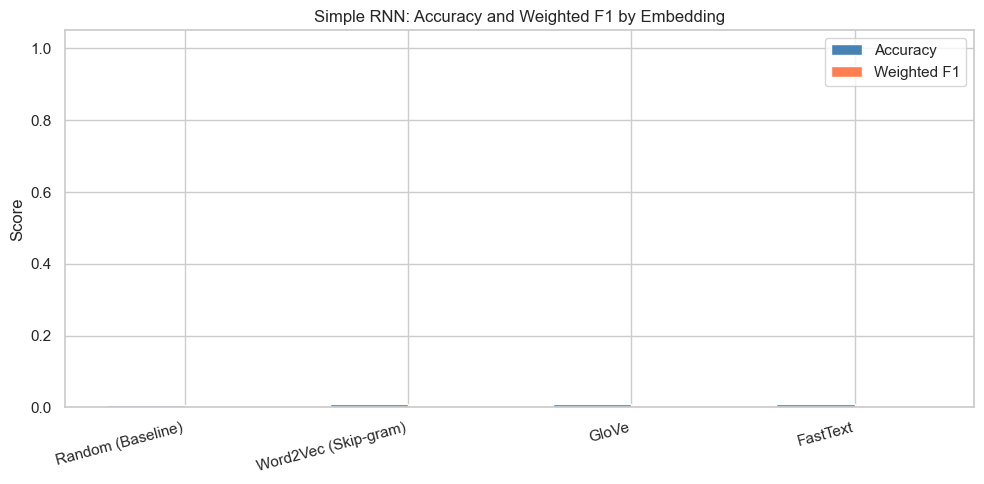

Plot saved to data/rnn_embedding_comparison.png


In [23]:
# Performance comparison plot
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(results))
width = 0.35
ax.bar(x - width/2, results["Accuracy"], width, label="Accuracy", color="steelblue")
ax.bar(x + width/2, results["Weighted F1"], width, label="Weighted F1", color="coral")
ax.set_ylabel("Score")
ax.set_title("Simple RNN: Accuracy and Weighted F1 by Embedding")
ax.set_xticks(x)
ax.set_xticklabels(results["Embedding"], rotation=15, ha="right")
ax.legend()
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.savefig("data/rnn_embedding_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Plot saved to data/rnn_embedding_comparison.png")

---
## 12. Confusion Matrix (for Report)

Example confusion matrix for one configuration (e.g. best-performing embedding). Include in report for **Results & Comparative Discussion**.

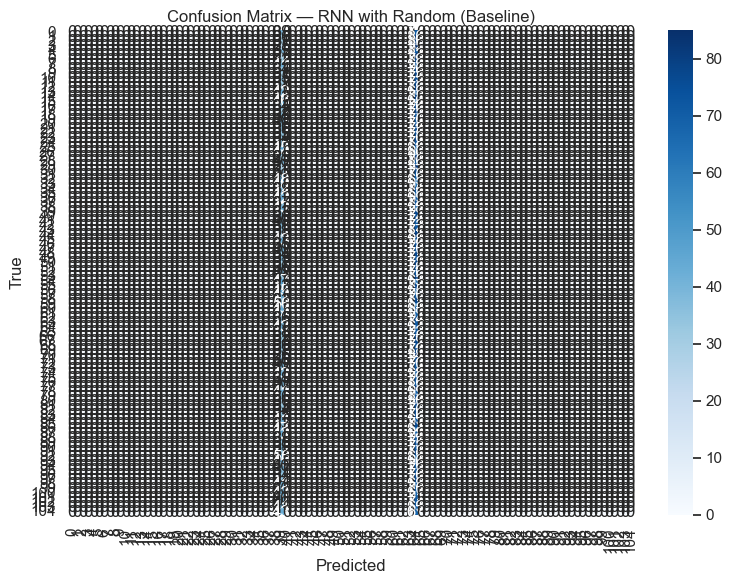

In [24]:
# Re-run best model (e.g. max F1) to get predictions for confusion matrix
best_name = results.loc[results["Weighted F1"].idxmax(), "Embedding"]
best_emb = {"Random (Baseline)": None, "Word2Vec (Skip-gram)": emb_w2v, "GloVe": emb_glove if emb_glove is not None else None, "FastText": emb_ft}[best_name]
if best_emb is None:
    best_emb = None
set_seed()
model_cm = MedicalRNN(vocab_size, EMBED_DIM, HIDDEN_DIM, num_classes, embedding_matrix=best_emb).to(device)
optimizer_cm = torch.optim.Adam(model_cm.parameters(), lr=LR)
for _ in range(NUM_EPOCHS):
    train_epoch(model_cm, train_loader, nn.CrossEntropyLoss(), optimizer_cm)
preds_cm = []
model_cm.eval()
with torch.no_grad():
    for X_b, _ in test_loader:
        preds_cm.extend(model_cm(X_b.to(device)).argmax(1).cpu().numpy())
cm = confusion_matrix(y_test, preds_cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, xticklabels=unique_labels, yticklabels=unique_labels, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — RNN with {best_name}")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("data/confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

---
## 13. Summary for Report (Copy-Ready)

- **Model:** Simple RNN (PyTorch), one-layer RNN, hidden_dim=128, dropout=0.3, Adam lr=1e-3, 5 epochs.
- **Preprocessing:** Shared pipeline: lowercase, remove punctuation except hyphens, remove medical + English stopwords, no lemmatization. Vocab: &lt;PAD&gt;=0, &lt;UNK&gt;=1; MAX_LEN=50.
- **Embeddings:** (1) Random init (baseline), (2) Word2Vec Skip-gram (gensim sg=1) on training corpus, (3) GloVe 6B 100d with OOV random init, (4) FastText trained on dataset.
- **Metrics:** Accuracy, Weighted F1 (and confusion matrix for best embedding).
- **Reproducibility:** Seed=42; same split and preprocessing for all experiments.

---
## 7. Experiment 1: Random Initialization (Baseline)

In [25]:
set_seed()
acc_rand, f1_rand = run_experiment(embedding_matrix=None, name="Random")
print(f"Random Init — Test Accuracy: {acc_rand:.4f}, Weighted F1: {f1_rand:.4f}")


Training Random - 5 epochs
Epoch  1/5 | Train Loss: 4.6571 | Val Acc: 0.0096 | Val F1: 0.0002 ⭐ (Best)
Epoch  2/5 | Train Loss: 4.7525 | Val Acc: 0.0103 | Val F1: 0.0017 ⭐ (Best)
Epoch  3/5 | Train Loss: 4.7536 | Val Acc: 0.0114 | Val F1: 0.0014
Epoch  4/5 | Train Loss: 4.7330 | Val Acc: 0.0087 | Val F1: 0.0019 ⭐ (Best)
Epoch  5/5 | Train Loss: 4.7280 | Val Acc: 0.0083 | Val F1: 0.0003

Best model at epoch 4: Val Acc: 0.0087, Val F1: 0.0019

Random Init — Test Accuracy: 0.0079, Weighted F1: 0.0020
